# Analysis

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib_venn import venn2, venn3
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
papers_df = pd.read_json('../data/papers_FOCS_ICML_NIPS_STOC_2000_2009_with_sch.json')
authors_df = pd.read_json('../data/authors_FOCS_ICML_NIPS_STOC_2000_2009_with_sch.json')

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

## Community, Conference and Year

/Users/shlomi/projects/does-author-order-matter/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


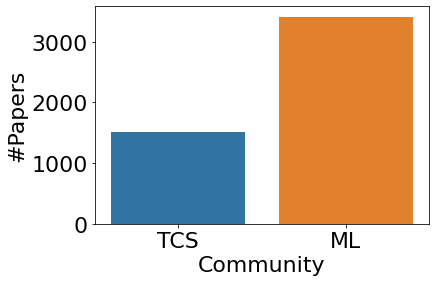

In [5]:
sns.countplot(papers_df['community'])
plt.xlabel('Community')
plt.ylabel('#Papers')
plt.savefig('../figures/community-papers.png', dpi=300)

In [6]:
papers_df['community'].value_counts()

ML     3414
TCS    1517
Name: community, dtype: int64

<AxesSubplot:xlabel='year'>

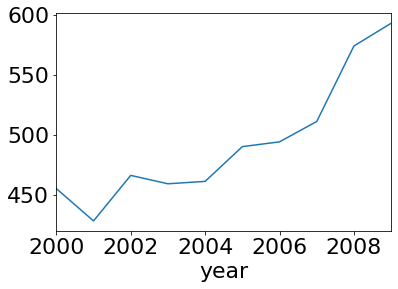

In [7]:
papers_df.groupby('year').size().plot()

<AxesSubplot:xlabel='year'>

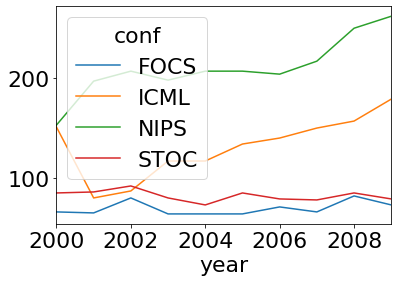

In [8]:
papers_df.groupby(['conf', 'year']).size().unstack().T.plot()

## Number of Authors

/Users/shlomi/projects/does-author-order-matter/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='n_author', ylabel='count'>

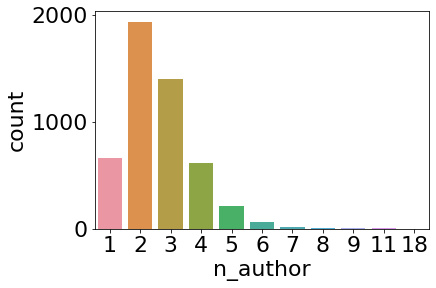

In [9]:
sns.countplot(papers_df['n_author'])

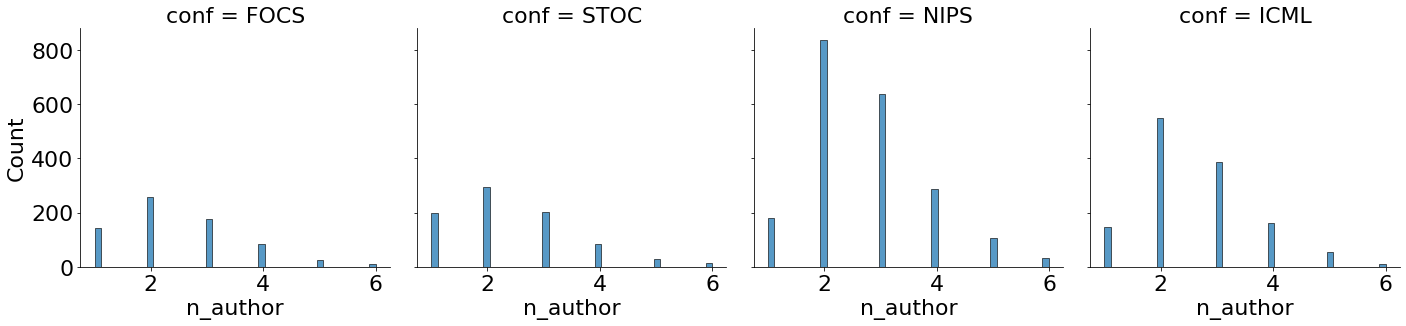

In [10]:
sns.displot(x='n_author', col='conf', kind='hist', data=papers_df[papers_df['n_author'] < 7]);

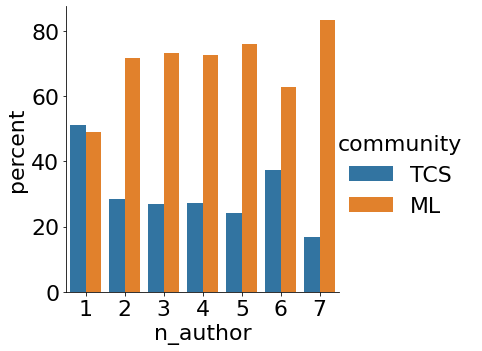

In [11]:
(papers_df[papers_df['n_author'] < 8]
.groupby('n_author')['community']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='n_author',y='percent',hue='community',kind='bar'))



#sns.histplot(x='n_author', hue='community', data=)

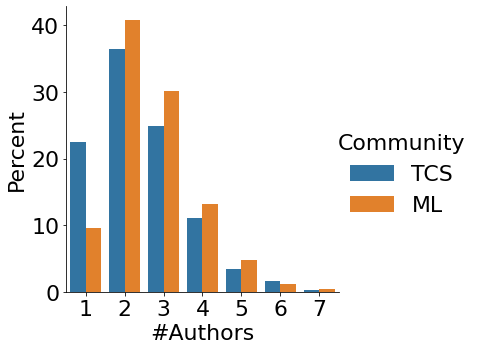

In [7]:
(papers_df[papers_df['n_author'] < 8].rename({'community': 'Community'}, axis=1)
.groupby('Community')['n_author']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
 .pipe((sns.catplot,'data'), x='n_author',y='percent',hue='Community',kind='bar', hue_order=['TCS', 'ML']))

plt.xlabel('#Authors')
plt.ylabel('Percent')

plt.savefig('../figures/community-n-authors.png', dpi=300)

In [16]:
n_author_per_conf = ((papers_df.groupby('conf')['n_author']
                      .value_counts(normalize=True)
                      .unstack()
                      .T
                      .fillna(0)
                      .round(3) * 100))

In [17]:
n_author_per_conf

conf,FOCS,ICML,NIPS,STOC
n_author,,,,
1,20.4,11.1,8.6,24.0
2,37.0,41.9,39.8,35.6
3,25.2,29.5,30.3,24.5
4,11.9,12.2,13.6,10.3
5,3.5,4.2,5.0,3.3
6,1.6,0.7,1.6,1.7
7,0.1,0.2,0.6,0.2
8,0.3,0.2,0.2,0.4
9,0.0,0.0,0.2,0.0


<AxesSubplot:xlabel='n_author'>

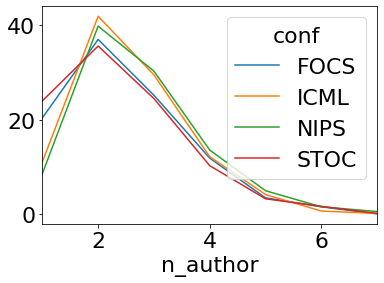

In [18]:
n_author_per_conf[n_author_per_conf.index < 8].plot()

<AxesSubplot:xlabel='n_author', ylabel='Proportion'>

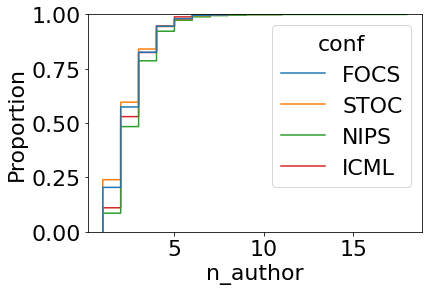

In [19]:
sns.ecdfplot(x='n_author', hue='conf', data=papers_df)

<AxesSubplot:xlabel='n_author', ylabel='Proportion'>

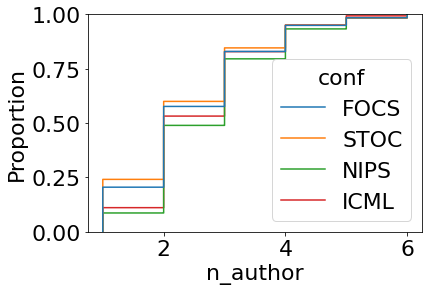

In [20]:
sns.ecdfplot(x='n_author', hue='conf', data=papers_df[papers_df['n_author'] < 7])

In [21]:
from scipy.stats import ks_2samp

ks_2samp(papers_df[papers_df['community'] == 'TCS']['n_author'],
         papers_df[papers_df['community'] == 'ML']['n_author'])

KstestResult(statistic=0.12827111907655436, pvalue=1.6057495710017952e-15)

In [22]:
papers_df.groupby('community')['n_author'].describe()

,count,mean,std,min,25%,50%,75%,max
community,,,,,,,,
ML,3414.0,2.711482,1.191681,1.0,2.0,2.0,3.0,18.0
TCS,1517.0,2.442320,1.205803,1.0,2.0,2.0,3.0,8.0


## Alphabetic Order

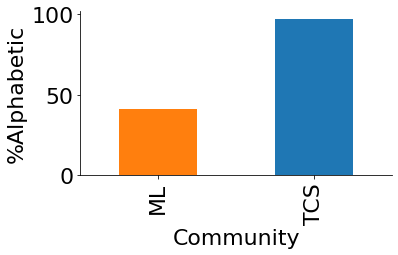

In [6]:

ax = (papers_df.groupby('community')['is_alphabetical']
 .mean()
 .mul(100)
# .pipe((sns.catplot,'data'), x='n_author',y='percent',hue='community',kind='bar'))
).plot(kind='bar', color=sns.color_palette()[:2][::-1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Community')
plt.ylabel('%Alphabetic')
plt.tight_layout()
plt.savefig('../figures/community_alpha.png', dpi=300)

In [ ]:
papers_df.groupby(['conf', 'year'])['is_alphabetical'].mean().unstack().T.plot()

## Authors 

In [32]:
len(authors_df)

5422

In [43]:
author_community = authors_df['community'].value_counts().sort_index(ascending=False)
author_major_community = authors_df['major_community'].value_counts().sort_index(ascending=False)

### TCS vs. ML communities

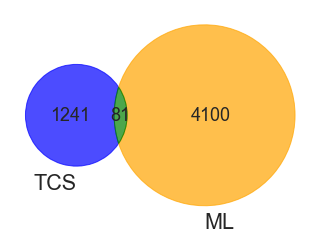

In [45]:
v = venn2(author_community, author_community.index);
v.get_patch_by_id('100').set_color('blue')
v.get_patch_by_id('100').set_alpha(0.7)
v.get_patch_by_id('010').set_color('orange')
v.get_patch_by_id('010').set_alpha(0.7)
v.get_patch_by_id('110').set_color('green')
v.get_patch_by_id('110').set_alpha(0.7)

plt.savefig('../figures/community-authors.png')

In [ ]:
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'))
v.get_patch_by_id('100').set_alpha(1.0)
v.get_patch_by_id('100').set_color('white')
v.get_label_by_id('100').set_text('Unknown')
v.get_label_by_id('A').set_text('Set "A"')

In [ ]:
venn2(author_major_community, author_community.index);

In [ ]:
conf_sets = authors_df['confs'].apply(set)

In [ ]:
def get_conf_authors(conf):
    return set(authors_df[authors_df['confs'].apply(lambda r: conf in r)].index)

venn2([get_conf_authors('ICML'), get_conf_authors('NIPS')], ['ICML', 'NIPS']);

In [ ]:
venn2([get_conf_authors('FOCS'), get_conf_authors('STOC')], ['FOCS', 'STOC']);

In [ ]:
authors_df.groupby('community')['n_coauthor'].describe()

### Adopting alphabetical order

In [ ]:
authors_df['community'].value_counts()

In [85]:
authors_df['major_community'].value_counts()

ML      4120
TCS     1280
BOTH      22
Name: major_community, dtype: int64

In [91]:
def community_is_alphabetical_by_authors(authors):
    return (papers_df[papers_df['authors']
     .apply(lambda r: any(author in authors for author in r))]
     .groupby('community')['is_alphabetical'])

common_authors = set(authors_df[authors_df['community'] == 'BOTH'].index)

community_is_alphabetical_by_authors(common_authors).mean()

community
ML     0.622754
TCS    0.957447
Name: is_alphabetical, dtype: float64

In [92]:
community_is_alphabetical_by_authors(common_authors).size()

community
ML     167
TCS    282
Name: is_alphabetical, dtype: int64

In [95]:
papers_df.groupby('community')['is_alphabetical'].mean()

community
ML     0.408026
TCS    0.970995
Name: is_alphabetical, dtype: float64

In [98]:
pd.DataFrame({'All': community_is_alphabetical_by_authors(authors_df.index).size(),
              'Major TCS': community_is_alphabetical_by_authors(authors_df[authors_df['major_community'] == 'TCS'].index).size(),
              'Major ML': community_is_alphabetical_by_authors(authors_df[authors_df['major_community'] == 'ML'].index).size(),
             })

,All,Major TCS,Major ML
community,,,
ML,3414,47,3403
TCS,1517,1513,23


It is not straightforward to come up with the right statistical hypothesis testing because the same paper might appear in more than one group. Nevertheless, for ML papers, the 95% CI for all is [0.3915, 04247] and [0.5069, 0.7914] for the major TCS.

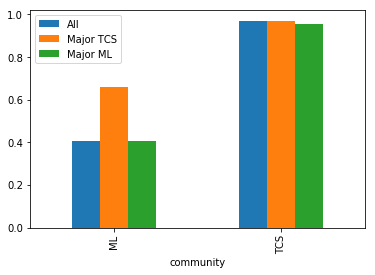

In [94]:
pd.DataFrame({'All': community_is_alphabetical_by_authors(authors_df.index).mean(),
              'Major TCS': community_is_alphabetical_by_authors(authors_df[authors_df['major_community'] == 'TCS'].index).mean(),
              'Major ML': community_is_alphabetical_by_authors(authors_df[authors_df['major_community'] == 'ML'].index).mean(),
             }).plot(kind='bar')

In [308]:
authors_df.groupby('community')['only_sing'].mean() * 100

community
BOTH    0.000000
ML      1.780488
TCS     4.190169
Name: only_sing, dtype: float64

## Independent variables

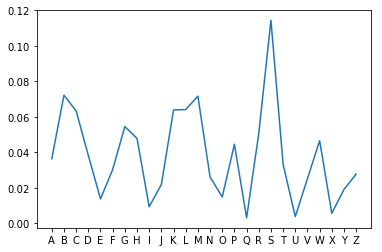

In [129]:
authors_df['letter_int'].value_counts(normalize=True).sort_index().plot()
plt.xticks(range(26), string.ascii_uppercase);

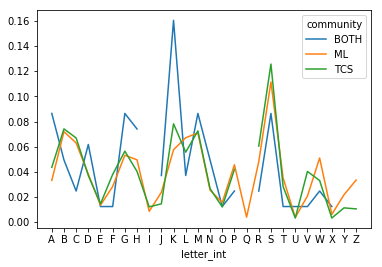

In [240]:
authors_df.groupby('community')['letter_int'].value_counts(normalize=True).unstack().T.plot()
plt.xticks(range(26), string.ascii_uppercase);

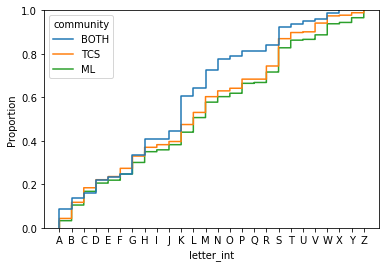

In [246]:
sns.ecdfplot(x='letter_int', hue='community', data=authors_df)
plt.xticks(range(26), string.ascii_uppercase);

In [262]:
ks_2samp(authors_df[authors_df['community'] == 'ML']['letter'],
         authors_df[authors_df['community'] == 'TCS']['letter'])

KstestResult(statistic=0.054177394312218706, pvalue=0.00712493931436875)

In [263]:
authors_df.groupby('community')['first_prop'].describe()

,count,mean,std,min,25%,50%,75%,max
community,,,,,,,,
BOTH,81.0,0.371942,0.341346,0.0,0.0,0.346154,0.6,1.0
ML,4027.0,0.385292,0.446078,0.0,0.0,0.000000,1.0,1.0
TCS,1189.0,0.357714,0.438578,0.0,0.0,0.000000,1.0,1.0


In [269]:
authors_df.groupby('community')['real_last_prop'].describe()

,count,mean,std,min,25%,50%,75%,max
community,,,,,,,,
BOTH,81.0,0.330818,0.324722,0.0,0.0,0.25,0.500000,1.0
ML,4027.0,0.280011,0.410115,0.0,0.0,0.00,0.537433,1.0
TCS,1189.0,0.333221,0.429915,0.0,0.0,0.00,0.875000,1.0


In [274]:
authors_df[~authors_df['only_sing']].groupby('community')['avg_coauthor'].describe()

,count,mean,std,min,25%,50%,75%,max
community,,,,,,,,
BOTH,81.0,1.601995,0.605159,0.500000,1.076923,1.5,2.0,4.0
ML,4027.0,2.265804,1.674092,0.200000,1.000000,2.0,3.0,17.0
TCS,1189.0,2.035157,1.190965,0.285714,1.000000,2.0,2.5,7.0


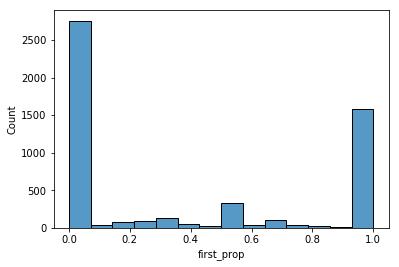

In [161]:
sns.histplot(authors_df['first_prop'])

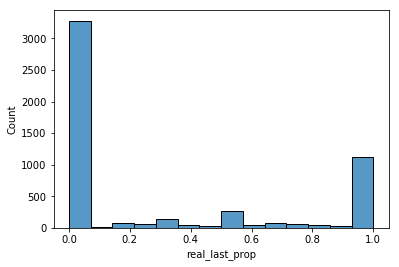

In [165]:
sns.histplot(authors_df['real_last_prop'])

/Users/shlomi/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


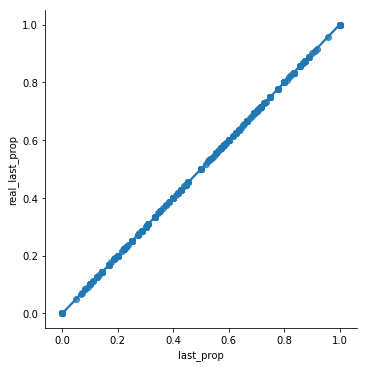

In [169]:
sns.lmplot('last_prop', 'real_last_prop', data=authors_df)

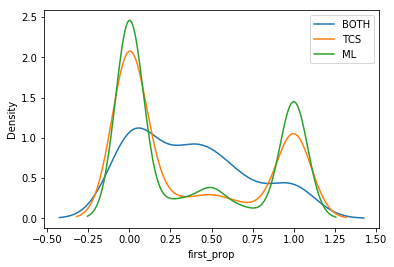

In [182]:
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    sns.kdeplot(data=community_df, x='first_prop', label=label)
plt.legend()

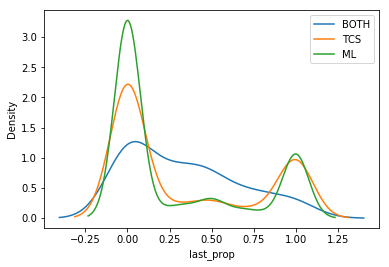

In [184]:
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    sns.kdeplot(data=community_df, x='last_prop', label=label)
plt.legend()

/Users/shlomi/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


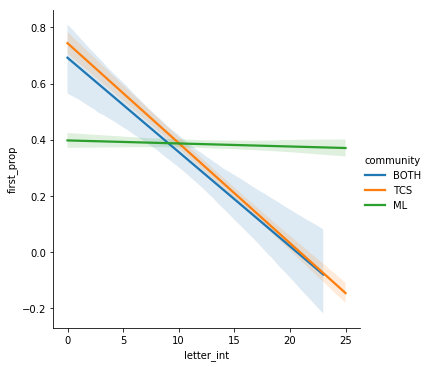

In [256]:
sns.lmplot('letter_int', 'first_prop', hue='community', scatter=False, data=authors_df)

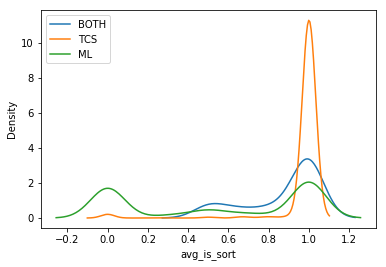

In [257]:
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    ax = sns.kdeplot(data=community_df, x='avg_is_sort', label=label)
    # ax.set_xscale('log')
plt.legend()

## Dependent variable

### Missing Data

In [196]:
authors_df['hindex'].isna().mean()

0.32183696053116934

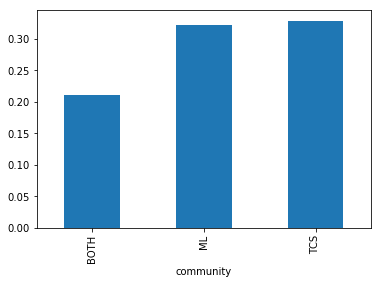

In [231]:
authors_df.groupby('community')['hindex'].apply(lambda g: g.isna().mean()).plot(kind='bar')

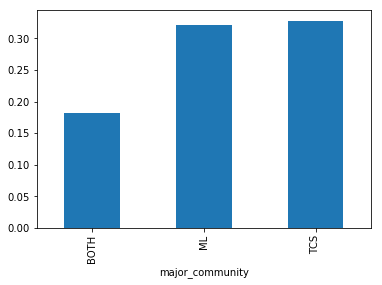

In [199]:
authors_df.groupby('major_community')['hindex'].apply(lambda g: g.isna().mean()).plot(kind='bar')

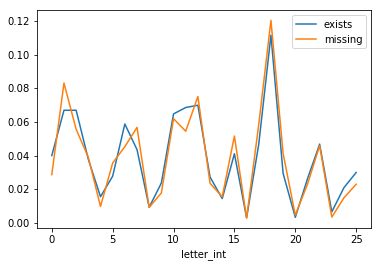

In [485]:
missing_hindex_by_letter = pd.DataFrame(
    {'exists': authors_df.groupby('letter_int')['hindex'].apply(lambda g: (~g.isna()).sum()),
     'missing': authors_df.groupby('letter_int')['hindex'].apply(lambda g: g.isna().sum())})
(missing_hindex_by_letter / missing_hindex_by_letter.sum(axis=0)).plot()

In [486]:
stats.chi2_contingency(missing_hindex_by_letter)[:2]

(50.76613388689697, 0.0017126756959771232)

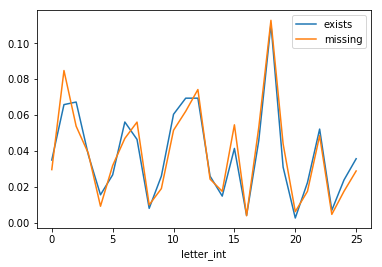

In [487]:
missing_ML_hindex_by_letter = pd.DataFrame(
    {'exists': authors_df[authors_df['community']=='ML'].groupby('letter_int')['hindex'].apply(lambda g: (~g.isna()).sum()),
     'missing': authors_df[authors_df['community']=='ML'].groupby('letter_int')['hindex'].apply(lambda g: g.isna().sum())})
(missing_ML_hindex_by_letter / missing_ML_hindex_by_letter.sum(axis=0)).plot()

In [495]:
stats.chi2_contingency(missing_ML_hindex_by_letter)[:2]

(36.26923579291865, 0.06761279871481096)

In [497]:
ks_2samp(missing_ML_hindex_by_letter['exists'],
         missing_ML_hindex_by_letter['missing'])

KstestResult(statistic=0.46153846153846156, pvalue=0.007134100565905311)

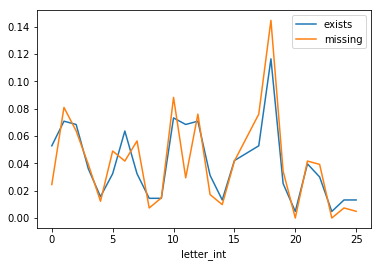

In [491]:
missing_TCS_hindex_by_letter = pd.DataFrame(
    {'exists': authors_df[authors_df['community']=='TCS'].groupby('letter_int')['hindex'].apply(lambda g: (~g.isna()).sum()),
     'missing': authors_df[authors_df['community']=='TCS'].groupby('letter_int')['hindex'].apply(lambda g: g.isna().sum())})
(missing_TCS_hindex_by_letter / missing_TCS_hindex_by_letter.sum(axis=0)).plot()

In [493]:
stats.chi2_contingency(missing_TCS_hindex_by_letter)[:2]

(38.09315421286028, 0.03391847538947859)

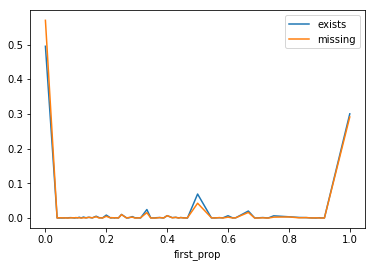

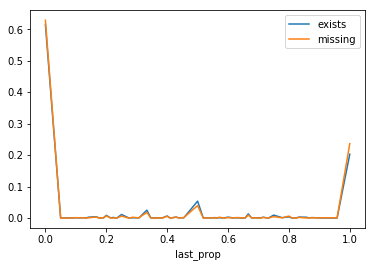

In [227]:
missing_hindex_by_first_prop = pd.DataFrame(
    {'exists': authors_df.groupby('first_prop')['hindex'].apply(lambda g: (~g.isna()).sum()),
     'missing': authors_df.groupby('first_prop')['hindex'].apply(lambda g: g.isna().sum())})
(missing_hindex_by_first_prop / missing_hindex_by_first_prop.sum(axis=0)).plot()

missing_hindex_by_last_prop = pd.DataFrame(
    {'exists': authors_df.groupby('last_prop')['hindex'].apply(lambda g: (~g.isna()).sum()),
     'missing': authors_df.groupby('last_prop')['hindex'].apply(lambda g: g.isna().sum())})
(missing_hindex_by_last_prop / missing_hindex_by_last_prop.sum(axis=0)).plot()

In [20]:
authors_df.groupby('race_perhaps').apply(lambda g: g['hindex'].isna().mean())

race_perhaps
Asian              0.229870
GreaterAfrican     0.321951
GreaterEuropean    0.360348
dtype: float64

## Dependet

,count,mean,std,min,25%,50%,75%,max
community,,,,,,,,
BOTH,64.0,42.640625,21.615961,4.0,28.0,37.5,55.25,104.0
ML,2780.0,38.717266,29.794702,0.0,18.0,31.0,51.00,236.0
TCS,833.0,34.980792,22.574920,0.0,20.0,30.0,45.00,166.0


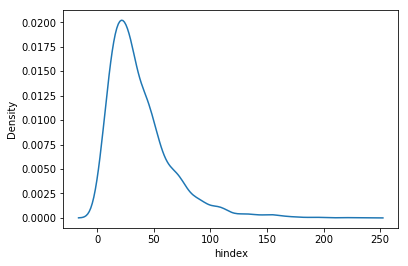

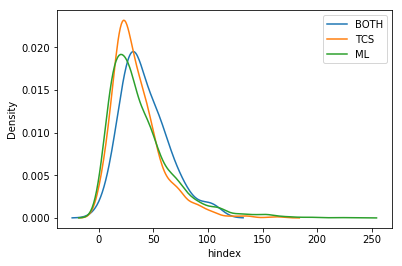

In [370]:
sns.kdeplot(x='hindex', data=authors_df)

_ = plt.figure()
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    sns.kdeplot(data=community_df, x='hindex', label=label)
plt.legend()

authors_df.groupby('community')['hindex'].describe()

,count,mean,std,min,25%,50%,75%,max
community,,,,,,,,
BOTH,64.0,612.474145,613.233148,6.142857,166.237939,373.112045,874.846316,2394.200000
ML,2780.0,683.716719,1337.596880,0.000000,106.660444,271.060150,688.808756,23265.933333
TCS,833.0,393.076689,700.238134,0.000000,88.789474,178.476190,402.407407,9858.818182


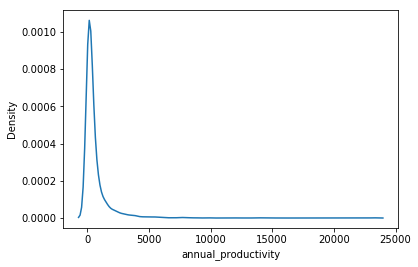

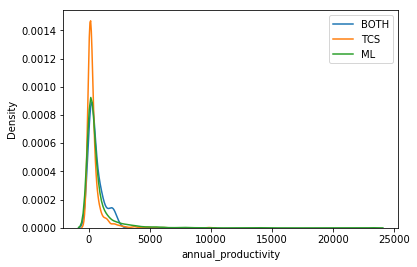

In [371]:
sns.kdeplot(x='annual_productivity', data=authors_df)

_ = plt.figure()
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    sns.kdeplot(data=community_df, x='annual_productivity', label=label)
plt.legend()

authors_df.groupby('community')['annual_productivity'].describe()

## Controls

,count,mean,std,min,25%,50%,75%,max
community,,,,,,,,
BOTH,64.0,21.656250,6.164977,7.0,18.0,20.0,24.25,41.0
ML,2780.0,20.631295,6.986778,1.0,16.0,20.0,24.00,41.0
TCS,833.0,22.300120,7.424538,1.0,17.0,21.0,27.00,41.0


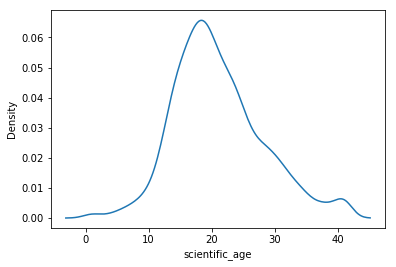

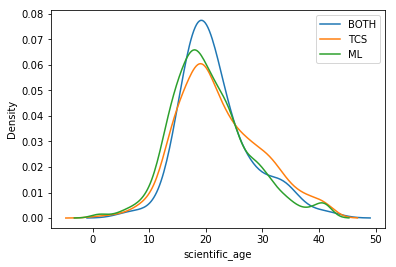

In [281]:
sns.kdeplot(x='scientific_age', data=authors_df)

_ = plt.figure()
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    sns.kdeplot(data=community_df, x='scientific_age', label=label)
plt.legend()

authors_df.groupby('community')['scientific_age'].describe()

,count,mean,std,min,25%,50%,75%,max
community,,,,,,,,
BOTH,64.0,14238.125000,16543.784122,43.0,3517.75,7044.5,18096.50,78773.0
ML,2780.0,14794.097482,28534.506930,0.0,2001.50,5557.5,14481.75,361042.0
TCS,833.0,9323.097239,16817.820447,0.0,1671.00,3867.0,9888.00,244389.0


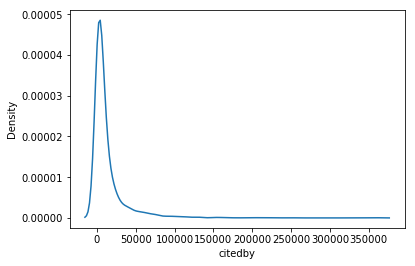

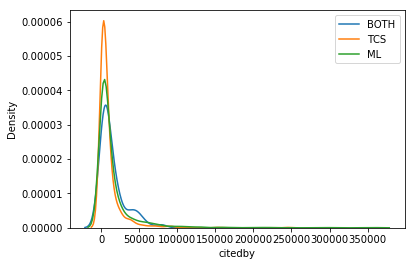

In [282]:
sns.kdeplot(x='citedby', data=authors_df)

_ = plt.figure()
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    sns.kdeplot(data=community_df, x='citedby', label=label)
plt.legend()

authors_df.groupby('community')['citedby'].describe()

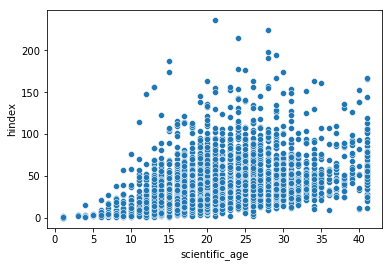

In [367]:
ax = sns.scatterplot(x='scientific_age', y='hindex', data=authors_df)

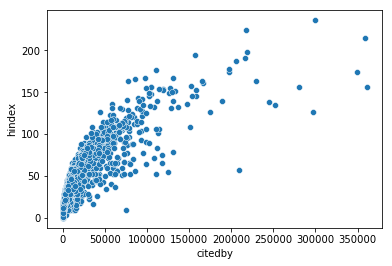

In [365]:
ax = sns.scatterplot(x='citedby', y='hindex', data=authors_df)

## All variable correlation

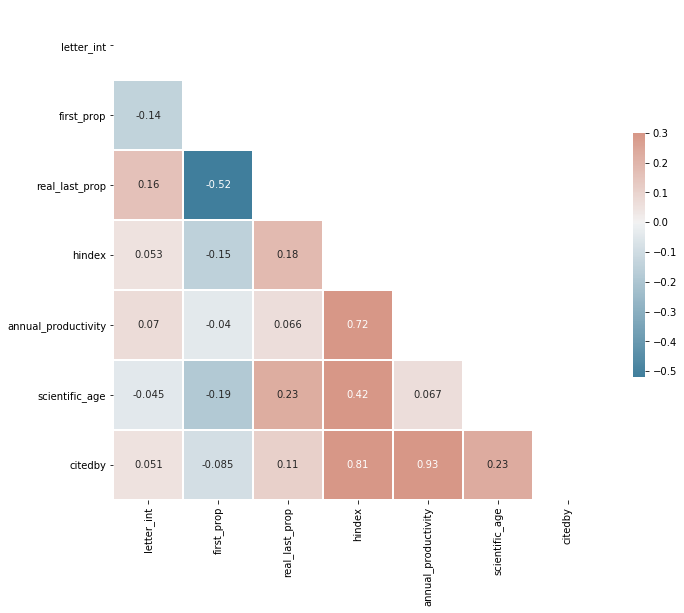

In [363]:
corr = authors_df[['letter_int', 'first_prop', 'real_last_prop', 'hindex', 'annual_productivity', 'scientific_age', 'citedby']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True)

In [428]:
q = authors_df[authors_df['community'] == 'ML']

/Users/shlomi/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


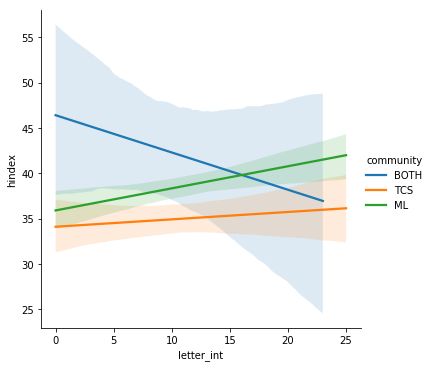

In [501]:
sns.lmplot('letter_int', 'hindex', hue='community', scatter=False, data=authors_df)

/Users/shlomi/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


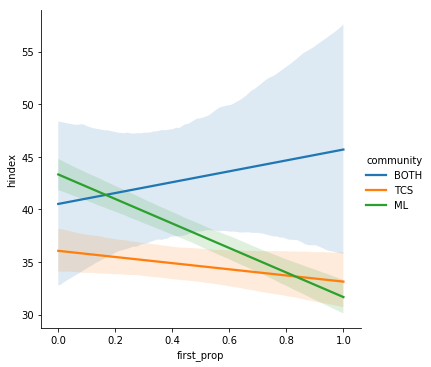

In [503]:
sns.lmplot('first_prop', 'hindex', hue='community', scatter=False, data=authors_df)

## With whom writing papers? - TODO MAYBER LATTER

/Users/shlomi/projects/does-author-order-matter/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


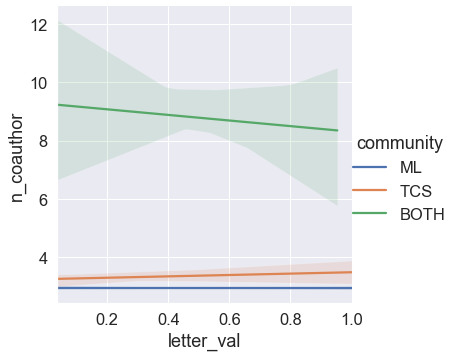

In [154]:
sns.lmplot('letter_val', 'n_coauthor', hue='community',
           robust=True, n_boot=10,
           scatter=False, data=authors_df)

In [528]:
(smf.ols('n_coauthor ~ letter_val * community', data=authors_df[authors_df['community'] == 'TCS'])
 .fit().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_coauthor   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.194
Date:                Mon, 07 Dec 2020   Prob (F-statistic):              0.275
Time:                        16:10:13   Log-Likelihood:                -3642.5
No. Observations:                1241   AIC:                             7289.
Df Residuals:                    1239   BIC:                             7299.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2055      0.266     15.817      0.000       3.684       4.727
letter_val     0.4969      0.455      1.093      0.275      -0.395       1.389
==============================================================================
Omnibus:                      584.313   Durbin-Watson:                   1.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2822.029
Skew:                           2.235   Prob(JB):                         0.00
Kurtosis:                       8.882   Cond. No.                         4.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
(smf.rlm('n_coauthor ~ letter_val', data=authors_df[authors_df['community'] == 'TCS'])
 .fit().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:             n_coauthor   No. Observations:                 1241
Model:                            RLM   Df Residuals:                     1239
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 08 Dec 2020                                         
Time:                        12:16:11                                         
No. Iterations:                    18                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2566      0.156     20.924      0.000       2.952       3.562
letter_val     0.2347      0.266      0.882      0.378      -0.287       0.756
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [142]:
authors_df.columns

Index(['stand_name', 'confs', 'communities', 'community', 'community_ratio',
       'major_community', 'multi', 'real_name', 'papers_authors', 'coauthors',
       'n_pub', 'n_coauthor', 'stand_coauthors', 'avg_is_sort', 'only_sing',
       'coauthors_letter', 'positions', 'first_prop', 'last_prop', 'letter',
       'letter_int', 'letter_val', 'status', 'affiliation', 'citedby',
       'citedby5y', 'cites_per_year', 'email', 'hindex', 'hindex5y',
       'i10index', 'i10index5y', 'id', 'interests', 'url_picture',
       'scientific_age', 'annual_productivity', 'real_last_prop',
       'avg_coauthor', 'aliases_sch', 'authorId_sch',
       'influentialCitationCount_sch', 'papers_sch', 'name_sch', 'url_sch',
       'n_pub_sch', 'scientific_birth_year_sch', 'scientific_age_sch',
       'annual_productiviy_sch', 'first_name', 'middle_name', 'last_name',
       'race', 'Asian,GreaterEastAsian,EastAsian',
       'Asian,GreaterEastAsian,Japanese', 'Asian,IndianSubContinent',
       'GreaterAfric

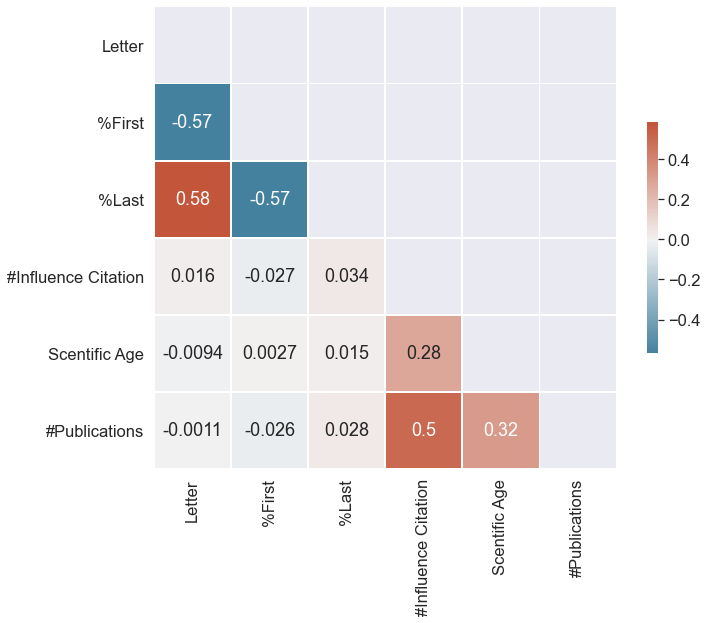

In [31]:
corr = authors_df[authors_df['community'] == 'TCS'][['letter_int', 'first_prop', 'real_last_prop', 'influentialCitationCount_sch', 'scientific_age_sch', 'n_pub_sch']].corr()
#sns.set_style("whitegrid")

sns.set(font_scale=1.5)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

ticket_label = ['Letter', '%First', '%Last', '#Influence Citation', 'Scentific Age', '#Publications']
sns.set_style("whitegrid")


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            xticklabels=ticket_label,
            yticklabels=ticket_label,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True)

plt.tight_layout()
plt.savefig('../figures/corr-tcs.png', dpi=300)

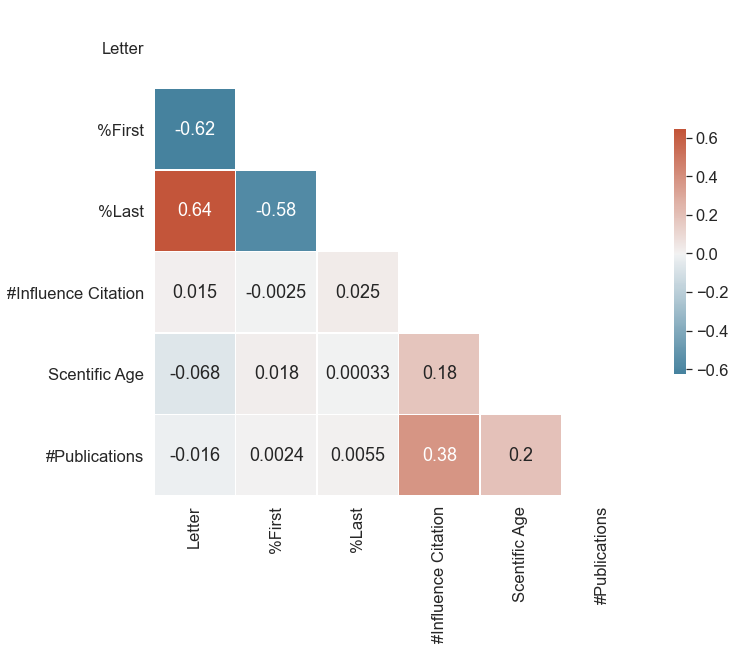

In [156]:
corr = authors_df[(authors_df['community'] == 'TCS')
                  &(authors_df['influentialCitationCount_sch'] >=authors_df['influentialCitationCount_sch'].median())][['letter_int', 'first_prop', 'real_last_prop', 'influentialCitationCount_sch', 'scientific_age_sch', 'n_pub_sch']].corr()
sns.set_style("whitegrid")

#sns.set(font_scale=1.5)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

ticket_label = ['Letter', '%First', '%Last', '#Influence Citation', 'Scentific Age', '#Publications']



# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            xticklabels=ticket_label,
            yticklabels=ticket_label,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True)

plt.savefig('../')

## Regression Models

In [12]:
authors_df['race_perhaps'] = authors_df['race'].str.split(',').str[0]

In [53]:
results = []

for independed_variable in ['letter_int', 'first_prop', 'real_last_prop']:
    for family in ['ols', 'quantreg', 'rlm', 'log']:
        for threshold in [1, authors_df['influentialCitationCount_sch'].median()]:
            for community in ['TCS']:
                formula = f'influentialCitationCount_sch ~ scientific_age_sch + {independed_variable} + race_perhaps'
                if family == 'log':
                    family = 'ols'
                    formula = f'np.log(influentialCitationCount_sch) ~ np.log(scientific_age_sch) + np.log({independed_variable}+1) + race_perhaps'
                model = (getattr(smf, family)(formula=formula,
                           data=authors_df[(authors_df['community'] == community)
                           & (authors_df['influentialCitationCount_sch'] >= threshold)])
                             .fit())
                    #results.append({'independed_variable': independed_variable,
                    #                  'family': family,
                    #                  'hindex_threshold': hindex_threshold,
                    #                  'community': community,
                    #                  'id_p': model.pvalues[independed_variable],
                    #                  'sa_p': model.pvalues['scientific_age'],
                    #                  'id_t': model.tvalues[independed_variable],
                    #                  'sa_t': model.tvalues['scientific_age'],
                    #                  #'adj_r^2': model.rsquared_adj,
                    #                  'nobs': model.nobs})
                print(community, threshold, model.summary())
                                      
#pd.DataFrame(results)

TCS 1                                  OLS Regression Results                                 
Dep. Variable:     influentialCitationCount_sch   R-squared:                       0.078
Model:                                      OLS   Adj. R-squared:                  0.075
Method:                           Least Squares   F-statistic:                     25.61
Date:                          Tue, 08 Dec 2020   Prob (F-statistic):           2.11e-20
Time:                                  14:06:24   Log-Likelihood:                -9839.8
No. Observations:                          1221   AIC:                         1.969e+04
Df Residuals:                              1216   BIC:                         1.972e+04
Df Model:                                     4                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----

TCS 209.0                          Robust linear Model Regression Results                         
Dep. Variable:     influentialCitationCount_sch   No. Observations:                  591
Model:                                      RLM   Df Residuals:                      586
Method:                                    IRLS   Df Model:                            4
Norm:                                    HuberT                                         
Scale Est.:                                 mad                                         
Cov Type:                                    H1                                         
Date:                          Tue, 08 Dec 2020                                         
Time:                                  14:06:24                                         
No. Iterations:                              13                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]


TCS 1                               QuantReg Regression Results                               
Dep. Variable:     influentialCitationCount_sch   Pseudo R-squared:              0.08271
Model:                                 QuantReg   Bandwidth:                       109.5
Method:                           Least Squares   Sparsity:                        477.4
Date:                          Tue, 08 Dec 2020   No. Observations:                 1170
Time:                                  14:06:24   Df Residuals:                     1165
                                                  Df Model:                            4
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -128.9639     22.087     -5.839      0.000    -172.300     -85.628
race_perhaps[T.GreaterAfrican]     14.6782     33.695      0.436      0

TCS 209.0                                  OLS Regression Results                                 
Dep. Variable:     influentialCitationCount_sch   R-squared:                       0.034
Model:                                      OLS   Adj. R-squared:                  0.028
Method:                           Least Squares   F-statistic:                     5.046
Date:                          Tue, 08 Dec 2020   Prob (F-statistic):           0.000530
Time:                                  14:06:24   Log-Likelihood:                -4721.7
No. Observations:                           571   AIC:                             9453.
Df Residuals:                               566   BIC:                             9475.
Df Model:                                     4                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]


TCS 1                          Robust linear Model Regression Results                         
Dep. Variable:     influentialCitationCount_sch   No. Observations:                 1170
Model:                                      RLM   Df Residuals:                     1165
Method:                                    IRLS   Df Model:                            4
Norm:                                    HuberT                                         
Scale Est.:                                 mad                                         
Cov Type:                                    H1                                         
Date:                          Tue, 08 Dec 2020                                         
Time:                                  14:06:25                                         
No. Iterations:                              18                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
----

In [11]:
results = []

for independed_variable in ['letter_int', 'first_prop', 'real_last_prop']:
    for family in ['ols', 'quantreg', 'rlm', 'log']:
        for threshold in [1, authors_df['influentialCitationCount_sch'].median()]:
            for community in ['TCS']:
                formula = f'influentialCitationCount_sch ~ scientific_age_sch + {independed_variable}'
                if family == 'log':
                    family = 'ols'
                    formula = f'np.log(influentialCitationCount_sch) ~ np.log(scientific_age_sch) + np.log({independed_variable}+1)'
                model = (getattr(smf, family)(formula=formula,
                           data=authors_df[(authors_df['community'] == community)
                           & (authors_df['influentialCitationCount_sch'] >= threshold)])
                             .fit())
                    #results.append({'independed_variable': independed_variable,
                    #                  'family': family,
                    #                  'hindex_threshold': hindex_threshold,
                    #                  'community': community,
                    #                  'id_p': model.pvalues[independed_variable],
                    #                  'sa_p': model.pvalues['scientific_age'],
                    #                  'id_t': model.tvalues[independed_variable],
                    #                  'sa_t': model.tvalues['scientific_age'],
                    #                  #'adj_r^2': model.rsquared_adj,
                    #                  'nobs': model.nobs})
                print(community, threshold, model.summary())
                                      
#pd.DataFrame(results)

TCS 1                                  OLS Regression Results                                 
Dep. Variable:     influentialCitationCount_sch   R-squared:                       0.078
Model:                                      OLS   Adj. R-squared:                  0.076
Method:                           Least Squares   F-statistic:                     51.31
Date:                          Tue, 08 Dec 2020   Prob (F-statistic):           4.05e-22
Time:                                  14:31:35   Log-Likelihood:                -9839.8
No. Observations:                          1221   AIC:                         1.969e+04
Df Residuals:                              1218   BIC:                         1.970e+04
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------

TCS 1                                      OLS Regression Results                                     
Dep. Variable:     np.log(influentialCitationCount_sch)   R-squared:                       0.228
Model:                                              OLS   Adj. R-squared:                  0.227
Method:                                   Least Squares   F-statistic:                     180.3
Date:                                  Tue, 08 Dec 2020   Prob (F-statistic):           2.65e-69
Time:                                          14:31:35   Log-Likelihood:                -1993.4
No. Observations:                                  1221   AIC:                             3993.
Df Residuals:                                      1218   BIC:                             4008.
Df Model:                                             2                                         
Covariance Type:                              nonrobust                                         
                        

TCS 1                               QuantReg Regression Results                               
Dep. Variable:     influentialCitationCount_sch   Pseudo R-squared:              0.08261
Model:                                 QuantReg   Bandwidth:                       109.1
Method:                           Least Squares   Sparsity:                        476.2
Date:                          Tue, 08 Dec 2020   No. Observations:                 1170
Time:                                  14:31:36   Df Residuals:                     1167
                                                  Df Model:                            2
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -126.0000     19.206     -6.560      0.000    -163.682     -88.318
scientific_age_sch    13.0000      0.572     22.746      0.000      11.879      14.121
first_prop           -2

TCS 209.0                                  OLS Regression Results                                 
Dep. Variable:     influentialCitationCount_sch   R-squared:                       0.035
Model:                                      OLS   Adj. R-squared:                  0.031
Method:                           Least Squares   F-statistic:                     10.17
Date:                          Tue, 08 Dec 2020   Prob (F-statistic):           4.57e-05
Time:                                  14:31:36   Log-Likelihood:                -4721.7
No. Observations:                           571   AIC:                             9449.
Df Residuals:                               568   BIC:                             9462.
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------

TCS 209.0                                  OLS Regression Results                                 
Dep. Variable:     influentialCitationCount_sch   R-squared:                       0.035
Model:                                      OLS   Adj. R-squared:                  0.031
Method:                           Least Squares   F-statistic:                     10.17
Date:                          Tue, 08 Dec 2020   Prob (F-statistic):           4.57e-05
Time:                                  14:31:36   Log-Likelihood:                -4721.7
No. Observations:                           571   AIC:                             9449.
Df Residuals:                               568   BIC:                             9462.
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [19]:
results = []

for independed_variable in ['letter_int', 'first_prop', 'real_last_prop']:
    for family in ['ols', 'quantreg', 'rlm', 'log']:
        for threshold in [1, authors_df['hindex'].median()]:
            for community in ['ML']:
                formula = f'hindex ~ scientific_age + {independed_variable} + race_perhaps'
                if family == 'log':
                    family = 'ols'
                    formula = f'np.log(hindex) ~ np.log(scientific_age) + np.log({independed_variable}+1) + race_perhaps'
                model = (getattr(smf, family)(formula=formula,
                           data=authors_df[(authors_df['community'] == community)
                           & (authors_df['hindex'] >= threshold)])
                             .fit())
                    #results.append({'independed_variable': independed_variable,
                    #                  'family': family,
                    #                  'hindex_threshold': hindex_threshold,
                    #                  'community': community,
                    #                  'id_p': model.pvalues[independed_variable],
                    #                  'sa_p': model.pvalues['scientific_age'],
                    #                  'id_t': model.tvalues[independed_variable],
                    #                  'sa_t': model.tvalues['scientific_age'],
                    #                  #'adj_r^2': model.rsquared_adj,
                    #                  'nobs': model.nobs})
                print(community, threshold, model.summary())
                                      
#pd.DataFrame(results)

ML 1                             OLS Regression Results                            
Dep. Variable:                 hindex   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     157.9
Date:                Tue, 08 Dec 2020   Prob (F-statistic):          6.91e-122
Time:                        14:36:28   Log-Likelihood:                -13064.
No. Observations:                2774   AIC:                         2.614e+04
Df Residuals:                    2769   BIC:                         2.617e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Inter

ML 31.0                     Robust linear Model Regression Results                    
Dep. Variable:                 hindex   No. Observations:                 1417
Model:                            RLM   Df Residuals:                     1412
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 08 Dec 2020                                         
Time:                        14:36:28                                         
No. Iterations:                    13                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
In

ML 1                          QuantReg Regression Results                          
Dep. Variable:                 hindex   Pseudo R-squared:               0.1298
Model:                       QuantReg   Bandwidth:                       6.829
Method:                 Least Squares   Sparsity:                        45.88
Date:                Tue, 08 Dec 2020   No. Observations:                 2774
Time:                        14:36:29   Df Residuals:                     2769
                                        Df Model:                            4
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           2.2353      1.620      1.380      0.168      -0.941       5.412
race_perhaps[T.GreaterAfrican]     -2.1760      2.434     -0.894      0.371      -6.949       2.598
race_perhaps[T.GreaterEuropean]    -5.0588

ML 1                          QuantReg Regression Results                          
Dep. Variable:                 hindex   Pseudo R-squared:               0.1312
Model:                       QuantReg   Bandwidth:                       6.753
Method:                 Least Squares   Sparsity:                        46.53
Date:                Tue, 08 Dec 2020   No. Observations:                 2774
Time:                        14:36:29   Df Residuals:                     2769
                                        Df Model:                            4
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.1250      1.465     -0.085      0.932      -2.998       2.748
race_perhaps[T.GreaterAfrican]     -3.0004      2.469     -1.215      0.224      -7.842       1.842
race_perhaps[T.GreaterEuropean]    -4.7500

In [16]:
authors_df[(authors_df['community'] == community)
                           & (authors_df['hindex'] >= threshold)]

,stand_name,confs,communities,community,community_ratio,major_community,multi,real_name,papers_authors,coauthors,...,"GreaterAfrican,Muslim","GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic",race_perhaps
A. P. Yogananda,YOGANANDA P A,[ICML],[ML],ML,NaN,ML,False,A. P. Yogananda,"[[A. P. Yogananda, M. Narasimha Murty, Lakshmi...","[[M. Narasimha Murty, Lakshmi Gopal]]",...,0.005203,0.006642,0.005379,0.001260,0.001780,0.000394,0.003279,0.000757,0.000320,Asian
Aapo Hyvärinen,HYVRINEN AAPO,"[NIPS, NIPS, NIPS, ICML]","[ML, ML, ML, ML]",ML,NaN,ML,False,Aapo Hyvärinen,"[[Patrik O. Hoyer, Aapo Hyvärinen], [Jarmo Hur...","[[Patrik O. Hoyer], [Jarmo Hurri], [Jussi T. L...",...,0.073925,0.011275,0.019353,0.315441,0.052771,0.172232,0.113234,0.066944,0.024487,GreaterEuropean
Aaron Hertzmann,HERTZMANN AARON,"[NIPS, NIPS, NIPS, ICML]","[ML, ML, ML, ML]",ML,NaN,ML,False,Aaron Hertzmann,"[[Lorenzo Torresani, Aaron Hertzmann, Christop...","[[Lorenzo Torresani, Christoph Bregler], [Aaro...",...,0.002816,0.033069,0.006532,0.882221,0.006637,0.029044,0.010584,0.015038,0.008168,GreaterEuropean
Aaron J. Gruber,GRUBER J AARON,"[NIPS, NIPS]","[ML, ML]",ML,NaN,ML,False,Aaron J. Gruber,"[[Aaron J. Gruber, Sara A. Solla, James C. Hou...","[[Sara A. Solla, James C. Houk], [Peter Dayan,...",...,0.004651,0.029299,0.013762,0.875542,0.004814,0.023326,0.009868,0.021835,0.007882,GreaterEuropean
Aaron Morris,MORRIS AARON,[NIPS],[ML],ML,NaN,ML,False,Aaron Morris,"[[David I. Ferguson, Aaron Morris, Dirk Hähnel...","[[David I. Ferguson, Dirk Hähnel, Christopher ...",...,0.001558,0.465236,0.003450,0.466778,0.006904,0.004559,0.020486,0.015573,0.002177,GreaterEuropean
Aaron Wilson,WILSON AARON,[ICML],[ML],ML,NaN,ML,False,Aaron Wilson,"[[Aaron Wilson, Alan Fern, Soumya Ray, Prasad ...","[[Alan Fern, Soumya Ray, Prasad Tadepalli]]",...,0.001617,0.375910,0.002413,0.542964,0.007293,0.004133,0.015030,0.017998,0.017365,GreaterEuropean
Aarti Singh,SINGH AARTI,[NIPS],[ML],ML,NaN,ML,False,Aarti Singh,"[[Aarti Singh, Robert D. Nowak, Xiaojin Zhu 00...","[[Robert D. Nowak, Xiaojin Zhu 0001]]",...,0.008920,0.071052,0.002338,0.025758,0.010851,0.030920,0.034805,0.006172,0.051809,Asian
Abba Krieger,KRIEGER ABBA,[ICML],[ML],ML,NaN,ML,False,Abba Krieger,"[[Abba Krieger, Chuan Long, Abraham J. Wyner]]","[[Chuan Long, Abraham J. Wyner]]",...,0.009145,0.028148,0.032683,0.638890,0.009805,0.185913,0.009828,0.029541,0.038503,GreaterEuropean
Abdeslam Boularias,BOULARIAS ABDESLAM,[ICML],[ML],ML,NaN,ML,False,Abdeslam Boularias,"[[Abdeslam Boularias, Brahim Chaib-draa]]",[[Brahim Chaib-draa]],...,0.689176,0.040979,0.063653,0.015593,0.091151,0.009007,0.011496,0.007390,0.002056,GreaterAfrican
Abdullah Celik,CELIK ABDULLAH,[NIPS],[ML],ML,NaN,ML,False,Abdullah Celik,"[[Abdullah Celik, Milutin Stanacevic, Gert Cau...","[[Milutin Stanacevic, Gert Cauwenberghs]]",...,0.954271,0.007270,0.001247,0.006600,0.001351,0.001640,0.001128,0.001898,0.000714,GreaterAfrican


In [469]:
authors_df['hindex']

stand_name                                                 WIGDERSON AVI
confs                  [FOCS, FOCS, FOCS, FOCS, FOCS, FOCS, FOCS, FOC...
communities            [TCS, TCS, TCS, TCS, TCS, TCS, TCS, TCS, TCS, ...
community                                                            TCS
community_ratio                                                        0
major_community                                                      TCS
multi                                                              False
real_name                                                  Avi Wigderson
papers_authors         [[Michael Alekhnovich, Eli Ben-Sasson, Alexand...
coauthors              [[Michael Alekhnovich, Eli Ben-Sasson, Alexand...
n_pub                                                                 26
n_coauthor                                                            29
stand_coauthors        [[ALEKHNOVICH MICHAEL, BENSASSON ELI, RAZBOROV...
avg_is_sort                                        

In [458]:
authors_df['scientific_age'].value_counts()

19.0    270
18.0    248
17.0    241
20.0    214
21.0    214
16.0    206
15.0    195
23.0    178
14.0    176
22.0    175
24.0    174
13.0    131
25.0    122
26.0    118
28.0     95
29.0     92
27.0     86
12.0     82
31.0     78
30.0     72
41.0     61
32.0     52
11.0     50
33.0     48
34.0     40
10.0     36
35.0     33
9.0      24
8.0      23
38.0     22
37.0     19
36.0     17
1.0      15
6.0      15
39.0     14
7.0      13
40.0     12
4.0       7
5.0       6
3.0       3
Name: scientific_age, dtype: int64

0.13376334846774687

In [425]:
authors_two_major_communites_df = authors_df[authors_df['major_community'] != 'BOTH']
hindex_threshold = 1#authors_two_major_communites_df['hindex'].median()

print(hindex_median)

print(smf.ols(formula='hindex ~  letter_int * major_community',
         data=authors_two_major_communites_df[authors_two_major_communites_df['hindex'] > hindex_threshold])
 .fit()
 .summary())


31.0
                            OLS Regression Results                            
Dep. Variable:                 hindex   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.724
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           3.85e-05
Time:                        22:30:06   Log-Likelihood:                -17269.
No. Observations:                3632   AIC:                         3.455e+04
Df Residuals:                    3628   BIC:                         3.457e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
I

In [ ]:
print(smf.ols(formula='hindex ~ scientific_age + letter_int',
         data=authors_df[authors_df['community'] == 'TCS'])
 .fit()
 .summary())


print(smf.ols(formula='np.log(hindex) ~ scientific_age + letter_int',
         data=authors_df[(authors_df['community'] == 'TCS') & (authors_df['hindex']>0)])
 .fit()
 .summary())

print(smf.quantreg(formula='hindex ~ scientific_age + letter_int',
         data=authors_df[authors_df['community'] == 'TCS'])
 .fit()
 .summary())


print(smf.quantreg(formula='np.log(hindex) ~ scientific_age + letter_int',
         data=authors_df[(authors_df['community'] == 'TCS') & (authors_df['hindex']>0)])
 .fit()
 .summary())

In [338]:
(smf.ols(formula='hindex ~ first_prop',
         data=authors_df[authors_df['community'] == 'ML'])
 .fit()
 .summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 hindex   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     86.05
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           3.42e-20
Time:                        21:18:53   Log-Likelihood:                -13338.
No. Observations:                2780   AIC:                         2.668e+04
Df Residuals:                    2778   BIC:                         2.669e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     43.3278      0.746     58.062      0.000      41.865      44.791
first_prop   -11.6456      1.255     -9.277      0.000     -14.107      -9.184
==============================================================================
Omnibus:                     1053.692   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4529.013
Skew:                           1.813   Prob(JB):                         0.00
Kurtosis:                       8.095   Cond. No.                         2.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [334]:
(smf.ols(formula='hindex ~ last_prop',
         data=authors_df[authors_df['community'] == 'ML'])
 .fit()
 .summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 hindex   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     153.6
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           2.31e-34
Time:                        21:18:26   Log-Likelihood:                -13306.
No. Observations:                2780   AIC:                         2.662e+04
Df Residuals:                    2778   BIC:                         2.663e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.0602      0.666     51.119      0.000      32.754      35.367
last_prop     16.8826      1.362     12.392      0.000      14.211      19.554
==============================================================================
Omnibus:                     1059.645   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4606.761
Skew:                           1.819   Prob(JB):                         0.00
Kurtosis:                       8.151   Cond. No.                         2.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [336]:
(smf.ols(formula='hindex ~ letter_int',
         data=authors_df[authors_df['community'] == 'TCS'])
 .fit()
 .summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 hindex   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5347
Date:                Sun, 06 Dec 2020   Prob (F-statistic):              0.465
Time:                        21:18:40   Log-Likelihood:                -3777.5
No. Observations:                 833   AIC:                             7559.
Df Residuals:                     831   BIC:                             7569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.1031      1.433     23.802      0.000      31.291      36.915
letter_int     0.0815      0.111      0.731      0.465      -0.137       0.300
==============================================================================
Omnibus:                      269.389   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              881.322
Skew:                           1.561   Prob(JB):                    4.20e-192
Kurtosis:                       6.955   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [339]:
(smf.ols(formula='hindex ~ first_prop',
         data=authors_df[authors_df['community'] == 'TCS'])
 .fit()
 .summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 hindex   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.717
Date:                Sun, 06 Dec 2020   Prob (F-statistic):             0.0997
Time:                        21:19:11   Log-Likelihood:                -3776.4
No. Observations:                 833   AIC:                             7557.
Df Residuals:                     831   BIC:                             7566.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0752      1.025     35.184      0.000      34.063      38.088
first_prop    -2.9253      1.775     -1.648      0.100      -6.409       0.558
==============================================================================
Omnibus:                      268.911   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              881.574
Skew:                           1.557   Prob(JB):                    3.70e-192
Kurtosis:                       6.962   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [340]:
(smf.ols(formula='hindex ~ last_prop',
         data=authors_df[authors_df['community'] == 'TCS'])
 .fit()
 .summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 hindex   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7092
Date:                Sun, 06 Dec 2020   Prob (F-statistic):              0.400
Time:                        21:19:15   Log-Likelihood:                -3777.4
No. Observations:                 833   AIC:                             7559.
Df Residuals:                     831   BIC:                             7568.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.4677      0.992     34.762      0.000      32.522      36.414
last_prop      1.5461      1.836      0.842      0.400      -2.058       5.150
==============================================================================
Omnibus:                      269.002   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              879.005
Skew:                           1.559   Prob(JB):                    1.34e-191
Kurtosis:                       6.949   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""